# IMPORT

In [ ]:
pip install holidays

In [ ]:
!pip install autogluon

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 224.0/224.0 kB 4.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 62.1/62.1 kB 7.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 285.7/285.7 kB 5.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 372.3/372.3 kB 7.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 116.3/116.3 kB 10.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 135.8/135.8 kB 7.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 61.1/61.1 kB 3.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 58.5/58.5 MB 8.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.7/4.7 MB 104.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 90.4/90.4 kB 14.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 43.6/43.6 kB 6.3 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 72.9/72.9 kB 10.3 MB/

In [ ]:
import random
import pandas as pd
import numpy as np
import os
import pandas as pd
import holidays
from sklearn.metrics import mean_squared_error
from autogluon.timeseries import TimeSeriesDataFrame, TimeSeriesPredictor



from sklearn.ensemble import RandomForestRegressor
from sklearn.preprocessing import LabelEncoder

import warnings
warnings.filterwarnings(action='ignore')

In [ ]:
def seed_everything(seed):
    random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    np.random.seed(seed)

seed_everything(42)

# DATA LOAD

In [ ]:
train_df = pd.read_csv('경로/train.csv')
test_df = pd.read_csv('경로/test.csv')

add_data_df = pd.read_csv('경로/international_trade.csv')

# PREPROCESSING

In [ ]:
# 연/월/일 컬럼 추가

train_df['year'] = train_df['timestamp'].apply(lambda x : int(x[0:4]))
train_df['month'] = train_df['timestamp'].apply(lambda x : int(x[5:7]))
train_df['day'] = train_df['timestamp'].apply(lambda x : int(x[8:10]))

test_df['year'] = test_df['timestamp'].apply(lambda x : int(x[0:4]))
test_df['month'] = test_df['timestamp'].apply(lambda x : int(x[5:7]))
test_df['day'] = test_df['timestamp'].apply(lambda x : int(x[8:10]))

In [ ]:
# 공휴일 정보 컬럼 추가

kr_holidays = holidays.KOR(years=range(2019, 2024))

train_df['timestamp'] = pd.to_datetime(train_df['timestamp'])
train_df['is_holiday'] = train_df['timestamp'].apply(lambda x: 1 if x in kr_holidays else 0)

test_df['timestamp'] = pd.to_datetime(test_df['timestamp'])
test_df['is_holiday'] = test_df['timestamp'].apply(lambda x: 1 if x in kr_holidays else 0)

In [ ]:
# 요일 컬럼 추가

train_df['weekday'] = train_df['timestamp'].dt.weekday
train_df.loc[train_df['weekday'] == 6, 'is_holiday'] = 1

test_df['weekday'] = test_df['timestamp'].dt.weekday
test_df.loc[test_df['weekday'] == 6, 'is_holiday'] = 1

In [ ]:
# 범주형 변수 라벨 인코딩

from sklearn.preprocessing import LabelEncoder

label_encoder = LabelEncoder()

train_df['item'] = label_encoder.fit_transform(train_df['item'])
test_df['item'] = label_encoder.transform(test_df['item'])

train_df['corporation'] = label_encoder.fit_transform(train_df['corporation'])
test_df['corporation'] = label_encoder.transform(test_df['corporation'])

train_df['location'] = label_encoder.fit_transform(train_df['location'])
test_df['location'] = label_encoder.transform(test_df['location'])

# train_df['year'] = label_encoder.fit_transform(train_df['year'])
# test_df['year'] = label_encoder.transform(test_df['year'])

In [ ]:
# 연, 월의 주기적 특성 컬럼 추

train_df['sin_month'] = np.sin(2 * np.pi * train_df['month'] / 12)
train_df['cos_month'] = np.cos(2 * np.pi * train_df['month'] / 12)
train_df['sin_day'] = np.sin(2 * np.pi * train_df['day'] / 31)
train_df['cos_day'] = np.cos(2 * np.pi * train_df['day'] / 31)

test_df['sin_month'] = np.sin(2 * np.pi * test_df['month'] / 12)
test_df['cos_month'] = np.cos(2 * np.pi * test_df['month'] / 12)
test_df['sin_day'] = np.sin(2 * np.pi * test_df['day'] / 31)
test_df['cos_day'] = np.cos(2 * np.pi * test_df['day'] / 31)

In [ ]:
# 분기 컬럼 추가
train_df['season'] = train_df['month'].apply(lambda x:
                                                0 if x in [12, 1, 2] else
                                                1 if x in [3, 4, 5] else
                                                2 if x in [6, 7, 8] else
                                                3 if x in [9, 10, 11] else None)

test_df['season'] = test_df['month'].apply(lambda x:
                                                0 if x in [12, 1, 2] else
                                                1 if x in [3, 4, 5] else
                                                2 if x in [6, 7, 8] else
                                                3 if x in [9, 10, 11] else None)

In [ ]:
# 코로나 가중치 생성

covid19 = pd.to_datetime('2020-05-01')
train_df['covid19'] = train_df['timestamp'].apply(lambda x: 0 if x < covid19 else 1)
test_df['covid19'] = test_df['timestamp'].apply(lambda x: 0 if x < covid19 else 1)

In [ ]:
# 컬럼 재배치

desired_columns = ['ID', 'timestamp', 'covid19', 'season', 'year', 'month', 'sin_month',  'cos_month',   'day',  'sin_day',   'cos_day', 'is_holiday', 'weekday', 'item', 'corporation', 'location', 'supply(kg)', 'price(원/kg)']
train_df = train_df[desired_columns]

desired_columns = ['ID', 'timestamp', 'covid19', 'season', 'year', 'month', 'sin_month',  'cos_month',   'day',  'sin_day',   'cos_day', 'is_holiday', 'weekday', 'item', 'corporation', 'location']
test_df = test_df[desired_columns]

In [ ]:
# 'price(원/kg)' 컬럼에서 100보다 작은 행 선택
filtered_rows = train_df[(train_df['price(원/kg)'] != 0) & (train_df['price(원/kg)'] < 100)]

# 결과 확인
print(filtered_rows)

                    ID  timestamp  covid19  season  year  month  sin_month  \
34018  RD_A_S_20200527 2020-05-27        1       1  2020      5   0.500000   
38546  RD_D_S_20200416 2020-04-16        0       1  2020      4   0.866025   
58084  RD_F_J_20190730 2019-07-30        0       2  2019      7  -0.500000   
58801  RD_F_J_20210716 2021-07-16        1       2  2021      7  -0.500000   
58811  RD_F_J_20210726 2021-07-26        1       2  2021      7  -0.500000   
58819  RD_F_J_20210803 2021-08-03        1       2  2021      8  -0.866025   

       cos_month  day   sin_day   cos_day  is_holiday  weekday  item  \
34018  -0.866025   27 -0.724793  0.688967           0        2     3   
38546  -0.500000   16 -0.101168 -0.994869           0        3     3   
58084  -0.866025   30 -0.201299  0.979530           0        1     3   
58801  -0.866025   16 -0.101168 -0.994869           0        4     3   
58811  -0.866025   26 -0.848644  0.528964           0        0     3   
58819  -0.500000    3

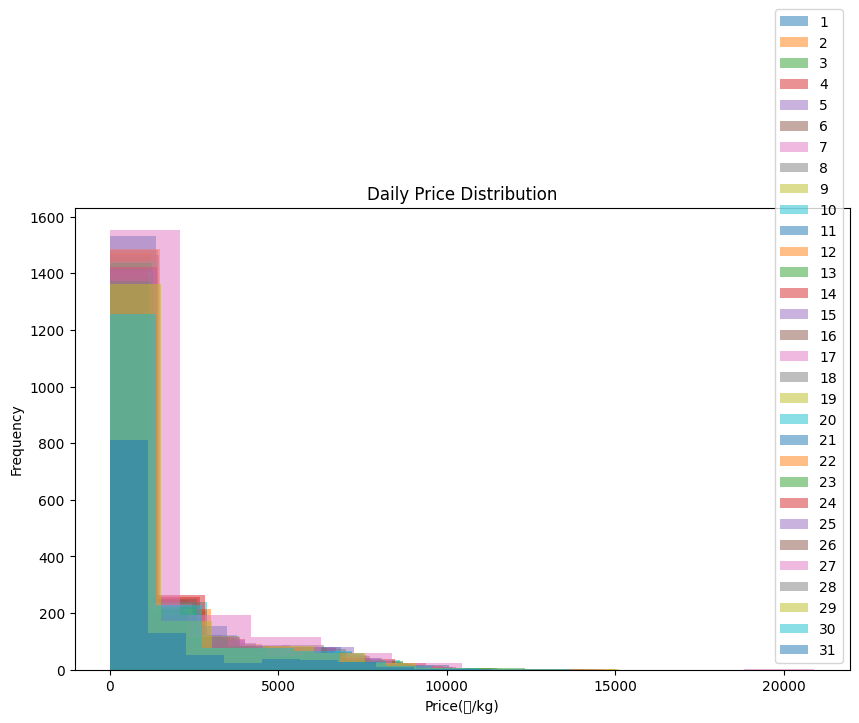

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt

# 데이터프레임 생성 (위의 데이터프레임 예시)
# train_df = pd.read_csv("your_data.csv")  # 실제 데이터 파일을 불러오는 경우에 사용

# 날짜 형식으로 변환
train_df['timestamp'] = pd.to_datetime(train_df['timestamp'])

# 일(day)별로 그룹화하고 가격(price)의 분포 확인
plt.figure(figsize=(10, 6))
train_df.groupby(train_df['timestamp'].dt.day)['price(원/kg)'].plot(kind='hist', alpha=0.5, legend=True)
plt.title('Daily Price Distribution')
plt.xlabel('Price(원/kg)')
plt.ylabel('Frequency')
plt.show()


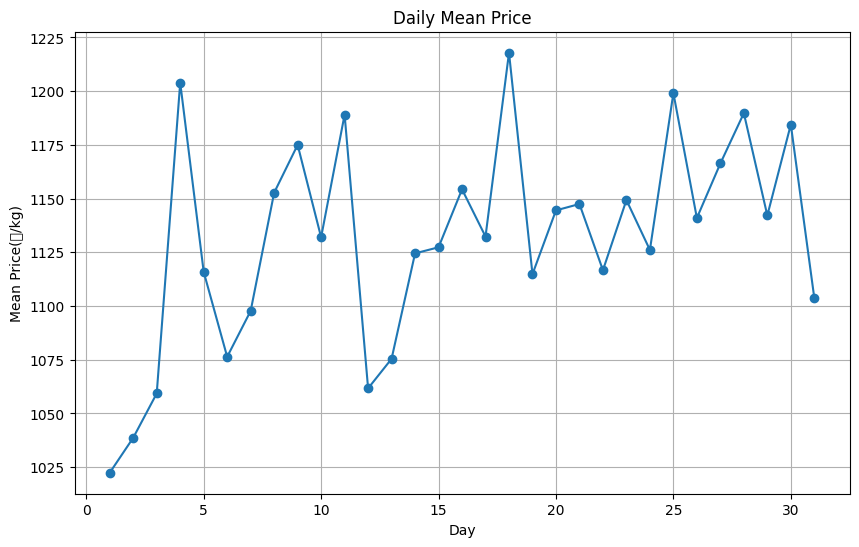

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt

# 데이터프레임 생성 (위의 데이터프레임 예시)
# train_df = pd.read_csv("your_data.csv")  # 실제 데이터 파일을 불러오는 경우에 사용

# 날짜 형식으로 변환
train_df['timestamp'] = pd.to_datetime(train_df['timestamp'])

# 일(day)별 가격(price)의 평균 계산
daily_price_mean = train_df.groupby(train_df['timestamp'].dt.day)['price(원/kg)'].mean()

# 가로가 날짜, 세로가 평균 가격인 선 그래프 그리기
plt.figure(figsize=(10, 6))
daily_price_mean.plot(marker='o', linestyle='-')
plt.title('Daily Mean Price')
plt.xlabel('Day')
plt.ylabel('Mean Price(원/kg)')
plt.grid(True)
plt.show()


In [ ]:
window_size = 7  # 7일 이동평균 사용

# 'supply(kg)'의 이동평균 계산 및 NaN 값을 0으로 채우기
train_df['supply_ma'] = train_df['supply(kg)'].rolling(window=window_size).mean().fillna(0)

# 'price(원/kg)'의 이동평균 계산 및 NaN 값을 0으로 채우기
train_df['price_ma'] = train_df['price(원/kg)'].rolling(window=window_size).mean().fillna(0)

In [ ]:
train_df['non_harvest_season'] = ((train_df['month'] >= 11) | (train_df['month'] <= 3)).astype(int)

# AutoGluon

In [ ]:
train_df['item_id'] = train_df.ID.str[0:6]

In [ ]:
train_df

,ID,timestamp,covid19,season,year,month,sin_month,cos_month,day,sin_day,...,weekday,item,corporation,location,supply(kg),price(원/kg),supply_ma,price_ma,non_harvest_season,item_id
0,TG_A_J_20190101,2019-01-01,0,0,2019,1,0.500000,8.660254e-01,1,0.201299,...,1,4,0,0,0.0,0.0,0.000000,0.000000,1,TG_A_J
1,TG_A_J_20190102,2019-01-02,0,0,2019,1,0.500000,8.660254e-01,2,0.394356,...,2,4,0,0,0.0,0.0,0.000000,0.000000,1,TG_A_J
2,TG_A_J_20190103,2019-01-03,0,0,2019,1,0.500000,8.660254e-01,3,0.571268,...,3,4,0,0,60601.0,1728.0,0.000000,0.000000,1,TG_A_J
3,TG_A_J_20190104,2019-01-04,0,0,2019,1,0.500000,8.660254e-01,4,0.724793,...,4,4,0,0,25000.0,1408.0,0.000000,0.000000,1,TG_A_J
4,TG_A_J_20190105,2019-01-05,0,0,2019,1,0.500000,8.660254e-01,5,0.848644,...,5,4,0,0,32352.0,1250.0,0.000000,0.000000,1,TG_A_J
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
59392,RD_F_J_20230227,2023-02-27,1,0,2023,2,0.866025,5.000000e-01,27,-0.724793,...,0,3,5,0,452440.0,468.0,394820.000000,370.857143,1,RD_F_J
59393,RD_F_J_20230228,2023-02-28,1,0,2023,2,0.866025,5.000000e-01,28,-0.571268,...,1,3,5,0,421980.0,531.0,368885.714286,378.857143,1,RD_F_J
59394,RD_F_J_20230301,2023-03-01,1,1,2023,3,1.000000,6.123234e-17,1,0.201299,...,2,3,5,0,382980.0,574.0,350397.142857,398.000000,1,RD_F_J
59395,RD_F_J_20230302,2023-03-02,1,1,2023,3,1.000000,6.123234e-17,2,0.394356,...,3,3,5,0,477220.0,523.0,350234.285714,416.142857,1,RD_F_J


In [ ]:
# # 사용하지 않는 변수 제거
# train_df = train_df.drop(columns=['day'])
# test_df = test_df.drop(columns=['day'])

In [ ]:
data = TimeSeriesDataFrame(train_df.drop(columns=['ID']))

predictor = TimeSeriesPredictor(
    prediction_length=28,
    target="price(원/kg)",
    eval_metric="RMSE",
)

predictor.fit(data, random_seed=600, )

================ TimeSeriesPredictor ================
TimeSeriesPredictor.fit() called
Fitting with arguments:
{'enable_ensemble': True,
 'evaluation_metric': 'RMSE',
 'excluded_model_types': None,
 'hyperparameter_tune_kwargs': None,
 'hyperparameters': 'default',
 'num_val_windows': 1,
 'prediction_length': 28,
 'random_seed': 600,
 'target': 'price(원/kg)',
 'time_limit': None,
 'verbosity': 2}
Provided training data set with 59397 rows, 39 items (item = single time series). Average time series length is 1523.0. Data frequency is 'D'.
INFO:lightning_fabric.utilities.seed:Global seed set to 600
AutoGluon will save models to AutogluonModels/ag-20231118_092627/
AutoGluon will gauge predictive performance using evaluation metric: 'RMSE'
	This metric's sign has been flipped to adhere to being 'higher is better'. The reported score can be multiplied by -1 to get the metric value.

Provided dataset contains following columns:
	target:           'price(원/kg)'
	past covariates:  ['covid19', '

In [ ]:
predictor.refit_full()

Refitting models via `refit_full` using all of the data (combined train and validation)...
	Models trained in this way will have the suffix '_FULL' and have NaN validation score.
	This process is not bound by time_limit, but should take less time than the original `fit` call.
Fitting model: Naive_FULL | Skipping fit via cloning parent ...
Fitting model: SeasonalNaive_FULL | Skipping fit via cloning parent ...
Fitting model: Theta_FULL | Skipping fit via cloning parent ...
Fitting model: AutoETS_FULL | Skipping fit via cloning parent ...
Fitting model: RecursiveTabular_FULL
	6.88    s     = Training runtime
Fitting model: DeepAR_FULL | Skipping fit via cloning parent ...
Fitting model: WeightedEnsemble_FULL | Skipping fit via cloning parent ...
Refit complete. Models trained: ['Naive_FULL', 'SeasonalNaive_FULL', 'Theta_FULL', 'AutoETS_FULL', 'RecursiveTabular_FULL', 'DeepAR_FULL', 'WeightedEnsemble_FULL']
Total runtime: 6.96 s
Updated best model to 'WeightedEnsemble_FULL' (Previously 'W

{'Naive': 'Naive_FULL',
 'SeasonalNaive': 'SeasonalNaive_FULL',
 'Theta': 'Theta_FULL',
 'AutoETS': 'AutoETS_FULL',
 'RecursiveTabular': 'RecursiveTabular_FULL',
 'DeepAR': 'DeepAR_FULL',
 'WeightedEnsemble': 'WeightedEnsemble_FULL'}

In [ ]:
data = TimeSeriesDataFrame(train_df.drop(columns=['ID']))

In [ ]:
# seed 고정
pred = predictor.predict(data, random_seed=42, )

INFO:lightning_fabric.utilities.seed:Global seed set to 42
Model not specified in predict, will default to the model with the best validation score: WeightedEnsemble_FULL


In [ ]:
pred.head(10)

mean          0.1          0.2          0.3  \
item_id timestamp                                                        
TG_A_J  2023-03-04  3244.107995   994.148531  1765.203310  2305.628104   
        2023-03-05   703.150373 -1986.781897 -1065.733420  -402.952703   
        2023-03-06  3106.061618  -469.239963   773.263000  1628.642896   
        2023-03-07  3392.602526  -611.449908   768.432388  1766.493855   
        2023-03-08  3293.484310 -1002.892084   469.572990  1537.344054   
        2023-03-09  3098.354136 -1616.971922    26.315800  1200.502431   
        2023-03-10  3205.598002 -1869.479495  -111.136337  1146.961445   
        2023-03-11  3131.217791 -2227.791463  -305.254085   999.250861   
        2023-03-12   655.608661 -4617.050941 -2791.343554 -1497.167815   
        2023-03-13  2931.136393 -2918.623442  -888.104421   527.276075   

                            0.4          0.5          0.6          0.7  \
item_id timestamp                                                        
TG_A_J  2023-03-04  2803.700514  3233.915979  3696.034004  4175.316218   
        2023-03-05   152.762021   665.607106  1196.454520  1756.475060   
        2023-03-06  2368.974995  3043.399877  3727.457330  4474.953873   
        2023-03-07  2599.849676  3372.599264  4167.267773  4983.379843   
        2023-03-08  2434.686285  3271.280370  4079.099831  4979.761046   
        2023-03-09  2189.741274  3101.985933  4035.506806  5024.897704   
        2023-03-10  2236.928408  3252.109808  4238.918753  5292.860095   
        2023-03-11  2114.528402  3145.340894  4196.926652  5319.296356   
        2023-03-12  -379.610400   659.986805  1687.627972  2798.375414   
        2023-03-13  1748.594326  2901.484149  4052.189901  5269.081426   

                            0.8          0.9  
item_id timestamp                             
TG_A_J  2023-03-04  4754.228270  5564.793529  
        2023-03-05  2412.339913  3323.025951  
        2023-03-06  5343.782842  6507.945406  
        2023-03-07  5944.743078  7399.524576  
        2023-03-08  6046.490960  7664.935976  
        2023-03-09  6175.799399  7817.337541  
        2023-03-10  6531.824195  8244.276623  
        2023-03-11  6628.017935  8443.872984  
        2023-03-12  4099.085684  5907.172209  
        2023-03-13  6745.911597  8754.194761

In [ ]:
# submission 파일에 예측 결과 추가
submission = pd.read_csv('경로/sample_submission.csv')
submission['answer'] = pred.reset_index()['mean']

for i in range(len(submission)):
    if submission.loc[i, 'answer'] < 50:
        submission.loc[i, 'answer'] = 0


# 'ID'에서 날짜 부분을 추출하고, 일요일인 경우 'answer' 값을 0으로 설정
submission['date'] = submission['ID'].str.extract(r'(\d{8})', expand=False).astype('datetime64')
sundays = submission['date'].dt.dayofweek == 6
submission.loc[sundays, 'answer'] = 0

# date열 삭제
submission.drop('date', axis=1, inplace=True)

# 결과 출력
print(submission)

# 예측 결과 저장
submission.to_csv('경로/파일명.csv', index=False)
submission

                   ID       answer
0     TG_A_J_20230304  3244.107995
1     TG_A_J_20230305     0.000000
2     TG_A_J_20230306  3106.061618
3     TG_A_J_20230307  3392.602526
4     TG_A_J_20230308  3293.484310
...               ...          ...
1087  RD_F_J_20230327   518.868098
1088  RD_F_J_20230328   524.603312
1089  RD_F_J_20230329   524.664742
1090  RD_F_J_20230330   497.842822
1091  RD_F_J_20230331   511.671153

[1092 rows x 2 columns]


,ID,answer
0,TG_A_J_20230304,3244.107995
1,TG_A_J_20230305,0.000000
2,TG_A_J_20230306,3106.061618
3,TG_A_J_20230307,3392.602526
4,TG_A_J_20230308,3293.484310
...,...,...
1087,RD_F_J_20230327,518.868098
1088,RD_F_J_20230328,524.603312
1089,RD_F_J_20230329,524.664742
1090,RD_F_J_20230330,497.842822
